In [29]:
import numpy as np
from scipy import linalg, special
from scipy.sparse import csr_matrix
import sympy
import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import cvxpy as cp
import copy
import requests
import xmltodict
from typing import Any, Iterable, Iterator, Mapping, Optional, Tuple, Union
from dataclasses import dataclass
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult


sns.set(style='darkgrid', palette='viridis', context='talk')


# Import simulation output

In [30]:
time = '10'
date = '2023-04-10'
experiment = 'fba-redux-standard'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [31]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [32]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [33]:
stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8"] # generate carbon mistake in parca, efflux/influx proton gen, iron cheating
for rxn in bad_rxns:
    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices.

In [34]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

,4
TRANS-RXN-300,14905204
TRANS-RXN-121,14905204
TRANS-RXN-145,4685215
ATPSYN-RXN (reverse),3622805
FUMHYDR-RXN__FUMARASE-A,1131615
FUMHYDR-RXN__FUMARASE-A (reverse),787822
GAPOXNPHOSPHN-RXN,429866
PHOSGLYPHOS-RXN (reverse),429864
2PGADEHYDRAT-RXN,429258
3PGAREARR-RXN (reverse),429210


# Change nutrient composition

In [35]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set(
    [
        # "D-Ribopyranose[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
    ]
)
removals = set(
                [
               #    "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
                ]
                )


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [36]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["target_maintenance_flux"]).at[4, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]          73
2-KETOGLUTARATE[c]               187
2-PG[c]                           49
2K-4CH3-PENTANOATE[c]             72
4-AMINO-BUTYRATE[c]              161
                              ...   
WATER[c]                    22086088
XYLULOSE-5-PHOSPHATE[c]           89
ZN+2[c]                           89
ZN+2[p]                           53
glycogen-monomer[c]            35110
Name: 4, Length: 172, dtype: int64

In [37]:
model = NetworkFlowModel(reactions=stoichiometry, homeostatic_metabolites=list(dict(homeostatic).keys()))

In [38]:
model.set_up_exchanges(exchanges=list(dict(exchanges).keys()), uptakes=uptake)

In [39]:
solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   binary_kinetic_targets={},
                                   objective_weights={'secretion': 0.001, 'efficiency': 0.00001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

In [27]:
pd.Series(solution.exchanges).sort_values(ascending=False).head(10)

WATER[p]              1.730667e+07
OXYGEN-MOLECULE[p]    1.431635e+06
GLC[p]                1.411259e+06
AMMONIUM[c]           1.366761e+06
Pi[p]                 1.776750e+05
K+[p]                 5.145700e+04
SULFATE[p]            1.428000e+04
MG+2[p]               2.287000e+03
FE+2[p]               1.930000e+03
CA+2[p]               1.425000e+03
dtype: float64

In [28]:
pd.Series(solution.velocities).sort_values(ascending=False).head(10)

TRANS-RXN-145                                                                   1.730667e+07
ATPSYN-RXN (reverse)                                                            4.997869e+06
maintenance_reaction                                                            3.058992e+06
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.           2.489249e+06
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse)     1.992032e+06
TRANS-RXN0-474                                                                  1.431583e+06
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.        1.430605e+06
GLU6PDEHYDROG-RXN-GLC-6-P/NADP//D-6-P-GLUCONO-DELTA-LACTONE/NADPH/PROTON.55.    1.295287e+06
6PGLUCONOLACT-RXN                                                               1.295287e+06
PYRUVDEH-RXN                                                                    1.219392e+06
dtype: float64

# Original

In [88]:
Sd = pd.DataFrame(stoichiometry, dtype=np.int8).fillna(0).astype(np.int8)


In [105]:
#stoich_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

mets_df = pd.DataFrame(Sd.index, columns=["Name"]) # index to name
rxns_df = pd.DataFrame(Sd.columns, columns=["Name"]) 

exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"])
maintenance = pd.DataFrame(fba["target_maintenance_flux"])
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])

kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])
kin_rxns = list(kinetic.keys())

homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())
intermediate_mets = list(set(mets_df["Name"]) - set(homeostatic.keys()))

n_mets, n_orig_rxns = Sd.shape

exchange_mets.extend(list(uptake))

Se = pd.DataFrame(index=Sd.index)

for met in exchange_mets:
    exch_name = met + " exchange"
    if met in uptake:
        Se[exch_name] = np.zeros(n_mets).astype(np.int8)
        Se.at[met, exch_name] = 1
    
    Se[exch_name + " rev"] = np.zeros(n_mets).astype(np.int8)
    Se.at[met, exch_name + " rev"] = -1
      
    
    
S_orig = np.array(Sd, dtype=np.float64)
S_exch = np.array(Se, dtype=np.float64)

_, n_exch_rxns = S_exch.shape


int_df = mets_df[mets_df['Name'].isin(intermediate_mets)].reset_index()
int_idx = list(int_df["index"])

hom_df = mets_df[mets_df['Name'].isin(homeostatic_mets)].reset_index()
target_hom = pd.DataFrame(homeostatic.loc[4, :]).reset_index(drop=False)
target_hom.columns = ["Name", "Count"]
merge_df = hom_df.set_index('Name').join(target_hom.set_index('Name'))

kin_df = rxns_df[rxns_df['Name'].isin(kin_rxns)].reset_index()
target_kin = pd.DataFrame(kinetic.loc[4, :]).reset_index(drop=False)
target_kin.columns = ["Name", "Flux"]
merge_kin_df = kin_df.set_index('Name').join(target_kin.set_index('Name'))

v_hom = np.array(merge_df["Count"]).astype(np.float64)
hom_idx = np.array(merge_df["index"]).astype(np.int64)

v_kin = np.array(merge_kin_df["Flux"]).astype(np.float64)
kin_idx = np.array(merge_kin_df["index"]).astype(np.int64)

v_main = np.array(fba["target_maintenance_flux"][4])
main_idx = list(Sd.columns).index("maintenance_reaction")


secretion_idx = np.where(S_exch.sum(axis=0) == -1)[0]

In [106]:
v = cp.Variable(n_orig_rxns)
e = cp.Variable(n_exch_rxns)
v_t = cp.hstack([v,e])
dm = S_orig @ v + S_exch @ e 


constr = []
constr.append(dm[int_idx] == 0)
constr.append(v[main_idx] == v_main)
# constr.append(dm[hom_idx] == v_hom)
constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

loss = 0
loss += cp.norm1(dm[hom_idx] - v_hom)
loss += 0.0001*(cp.sum(e[secretion_idx]))
loss += 0.00001*(cp.sum(v))
loss += 0.0000001 * cp.norm1(v[kin_idx] - v_kin)

In [107]:
p = cp.Problem(
        cp.Minimize(loss),
    constr
    )
               
p.solve(solver=cp.GLOP, verbose=False)

891.7414328911044

# Analyze output

In [108]:
exchange_rxns = Se.columns
exchange_nb = pd.DataFrame({exchange_rxns[i]: [e.value[i]] for i in range(len(exchange_rxns))}).sort_values(by=0, axis=1, ascending=False).T
exchange_nb = exchange_nb[exchange_nb[0] != 0]
index_raw = list(exchange_nb.index.str.split())
index_cleaned = [index_raw[i][0] for i in range(len(index_raw))]
exchange_nb.index = index_cleaned
exchange_nb.columns = ["Exchange flux"]
exchange_nb.head(5)

,Exchange flux
WATER[p],1.722097e+07
CARBON-DIOXIDE[p],2.078603e+06
OXYGEN-MOLECULE[p],1.517739e+06
GLC[p],1.425021e+06
AMMONIUM[c],1.366323e+06


In [109]:
exchange_sim = pd.DataFrame(exchanges.loc[4, :].abs().sort_values())
exchange_sim = exchange_sim[exchange_sim[4] != 0]
exchange_sim.columns = ["Exchange flux"]
exchange_sim.head(5)

,Exchange flux
S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE[c],10
CPD-1772[c],17
L-SELENOCYSTEINE[c],20
METOH[p],33
CPD-108[p],49


In [111]:
exch_comp = pd.merge(exchange_nb, exchange_sim, left_index=True, right_index=True, suffixes=(' new', ' standard'), how='outer').fillna(0).astype(np.int64)
exch_comp.sort_values(by="Exchange flux new", ascending=False).head(10)

,Exchange flux new,Exchange flux standard
WATER[p],17220969,18742975
CARBON-DIOXIDE[p],2078602,559251
OXYGEN-MOLECULE[p],1517739,3334
GLC[p],1425020,1169640
AMMONIUM[c],1366323,1366539
Pi[p],177675,177748
K+[p],51456,51457
SULFATE[p],14280,14288
MG+2[p],2287,2287
UNDECAPRENYL-DIPHOSPHATE[p],1999,2001


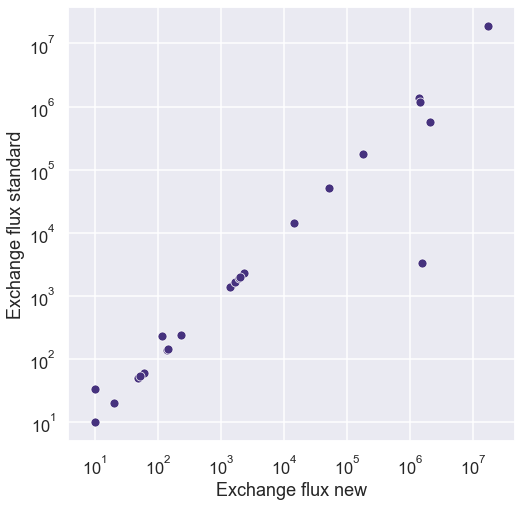

In [112]:
plt.figure(figsize=[8,8])

sns.scatterplot(x="Exchange flux new", y="Exchange flux standard", data=exch_comp)
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')

In [113]:
flux_indexed = list(Sd.columns[:n_orig_rxns])
fluxes = pd.DataFrame({flux_indexed[i]: [v.value[i], stoichiometry[flux_indexed[i]]] for i in range(len(flux_indexed))}).T
fluxes.sort_values(by=0, axis=0, ascending=False).head(15)

,0,1
TRANS-RXN-145,17220969.011255,"{'WATER[p]': -1, 'WATER[c]': 1}"
ATPSYN-RXN (reverse),5634574.458733,"{'ATP[c]': 1, 'WATER[c]': 1, 'PROTON[c]': 3, '..."
maintenance_reaction,3058991.943728,"{'ATP[c]': -1, 'WATER[c]': -1, 'ADP[c]': 1, 'P..."
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.,2661920.481242,"{'NADH[c]': -1, 'UBIQUINONE-8[i]': -1, 'PROTON..."
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),2078105.988746,"{'CARBON-DIOXIDE[p]': 1, 'CARBON-DIOXIDE[c]': -1}"
GAPOXNPHOSPHN-RXN,1662005.488745,"{'GAP[c]': -1, 'NAD[c]': -1, 'Pi[c]': -1, 'DPG..."
PHOSGLYPHOS-RXN (reverse),1661997.488745,"{'G3P[c]': 1, 'ATP[c]': 1, 'DPG[c]': -1, 'ADP[..."
TRANS-RXN0-474,1517687.238745,"{'OXYGEN-MOLECULE[p]': -1, 'OXYGEN-MOLECULE[c]..."
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.,1516708.738745,"{'CPD-9956[i]': -2, 'PROTON[c]': -8, 'OXYGEN-M..."
3PGAREARR-RXN (reverse),1476043.488745,"{'2-PG[c]': 1, 'G3P[c]': -1}"


In [114]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

,4
TRANS-RXN-300,14905204
TRANS-RXN-121,14905204
TRANS-RXN-145,4685215
ATPSYN-RXN (reverse),3622805
FUMHYDR-RXN__FUMARASE-A,1131615
FUMHYDR-RXN__FUMARASE-A (reverse),787822
GAPOXNPHOSPHN-RXN,429866
PHOSGLYPHOS-RXN (reverse),429864
2PGADEHYDRAT-RXN,429258
3PGAREARR-RXN (reverse),429210


In [115]:
exchanges.loc[4,:].abs().sort_values(ascending=False).head(10)

WATER[p]              18742975
AMMONIUM[c]            1366539
GLC[p]                 1169640
PROTON[p]              1166472
CARBON-DIOXIDE[p]       559251
Pi[p]                   177748
K+[p]                    51457
SULFATE[p]               14288
OXYGEN-MOLECULE[p]        3334
MG+2[p]                   2287
Name: 4, dtype: int64

In [116]:
dmdt_indexed = list(Sd.index)
# hom_idx
dmdt_dict = {dmdt_indexed[i]: [dm.value[i], v_hom[j], dm.value[i] - v_hom[j]] for j, i in enumerate(hom_idx)}
dmdt = pd.DataFrame(dmdt_dict).sort_values(by=0, axis=1).T
dmdt
#dmdt = pd.DataFrame({dmdt_indexed[i]: [dm.value[i], v_hom[j]] for j, i in enumerate(hom_idx)})
#dmdt.sort_values(by=0, axis=1, ascending=False).T.head(20)

,0,1,2
PPI[c],-91148.0,-91148.0,-1.164153e-10
PROTON[c],-32222.0,-32222.0,5.587935e-09
GMP[c],-8734.0,-8734.0,3.637979e-12
AMP[c],-8014.0,-8014.0,-2.910383e-11
CMP[c],-7777.0,-7777.0,2.182787e-11
...,...,...,...
GLY[c],55792.0,55792.0,-1.455192e-11
LEU[c],56225.0,56225.0,-7.275958e-12
GLT[c],56546.0,56546.0,2.328306e-10
L-ALPHA-ALANINE[c],70356.0,70356.0,-1.455192e-11


In [117]:
mets_df[mets_df.loc[:, "Name"].str.contains("FUM")]

,Name
576,FUM[c]
3678,FUM[p]
4506,FUM[e]


# Set up function

In [118]:
# inputs
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4,:]
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4,:]
maintenance = pd.DataFrame(fba["target_maintenance_flux"]).loc[4,:]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4,:]

exchange_mets = list(exchanges.keys())
homeostatic_mets = list(homeostatic.keys())
kin_rxns = list(kinetic.keys())

uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

stoichiometry

kin_rxns = list(kinetic.keys())
homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())

In [119]:
@dataclass
class FlowResult:
    """Reaction velocities and dm/dt for an FBA solution, with metrics."""
    velocities: Mapping[str, float]
    dm_dt: Mapping[str, float]
    exchanges: Mapping[str, float]
    objective: float
    # residual: Mapping[str, np.ndarray]

class NetworkFlowModel:

    def __init__(self,
                 reactions: Iterable[dict],
                 exchanges: Iterable[str],
                 uptakes: Iterable[str],
                 homeostatic_metabolites: Iterable[str]):

        # inputs: reactions: dict of dict
        # exchanges: list(set)
        # homeostatic: dict of str:floats (concs)

        # set up S matrix
        # homeostatic objective keys
        # exchange keys? if possible
        # reversibility is not needed as matrix already does it

        # pandas automatically creates S matrix from dict of dicts, then we fill zeros in remainder
        Sd = pd.DataFrame.from_dict(reactions, dtype=np.int8).fillna(0).astype(np.int8)
        self.n_mets, self.n_orig_rxns = Sd.shape

        # extract names of mets and rxns
        self.mets = list(Sd.index)
        self.rxns = list(Sd.columns)
        self.intermediates = list(set(self.mets) - set(homeostatic_metabolites))

        all_exchanges = exchanges.copy()
        all_exchanges.extend(uptakes)

        # Set up exchange rxns df
        Se = pd.DataFrame(index=Sd.index)

        for met in all_exchanges:
            exch_name = met + " exchange"
            if met in uptakes:
                Se[exch_name] = np.zeros(self.n_mets).astype(np.int8)
                Se.at[met, exch_name] = 1

            Se[exch_name + " rev"] = np.zeros(self.n_mets).astype(np.int8)
            Se.at[met, exch_name + " rev"] = -1

        self.S_orig = np.array(Sd, dtype=np.float64)
        self.S_exch = np.array(Se, dtype=np.float64)

        _, self.n_exch_rxns = self.S_exch.shape

        # steady state indices, secretion indices
        self.intermediates_idx = [self.mets.index(met) for met in self.intermediates]
        self.secretion_idx = np.where(self.S_exch.sum(axis=0) == -1)[0]

    def solve(self,
              homeostatic_targets: Mapping[str, float],
              maintenance_target: float,
              kinetic_targets: Mapping[str, float],
              **kwargs) -> FlowResult:

        # objective targets: dict of dicts to floats, for now
        ## kinetic
        ## maintenance
        ## homeostasis
        ## binary kinetic
        # starting fluxes: optional for now, could reintroduce
        #

        homeostatic_arr = [[self.mets.index(met), target] for met, target in homeostatic_targets.items()]
        homeostatic_idx, homeostatic_target = np.array(homeostatic_arr)[:, 0], np.array(homeostatic_arr)[:, 1]

        kinetic_array = [[self.rxns.index(met), target] for met, target in kinetic_targets.items()]
        kinetic_idx, kinetic_target = np.array(kinetic_array)[:, 0], np.array(kinetic_array)[:, 1]

        maintenance_idx = self.rxns.index("maintenance_reaction")  # TODO (Cyrus) - use name provided

        # set up variables
        v = cp.Variable(self.n_orig_rxns)
        e = cp.Variable(self.n_exch_rxns)
        dm = self.S_orig @ v + self.S_exch @ e

        constr = []
        constr.append(dm[self.intermediates_idx] == 0)
        constr.append(v[maintenance_idx] == maintenance_target)
        # constr.append(dm[homeostatic_idx[]] == homeostatic_target)
        constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

        loss = 0
        loss += cp.norm1(dm[homeostatic_idx] - homeostatic_target)
        loss += 0.001 * (cp.sum(e[self.secretion_idx]))
        loss += 0.00001 * (cp.sum(v))
        loss += 0.000001 * cp.norm1(v[kinetic_idx] - kinetic_target)

        p = cp.Problem(
            cp.Minimize(loss),
            constr
        )

        p.solve(solver=cp.GLOP, verbose=False)

        return FlowResult(velocities=v.value,
                          dm_dt=dm.value,
                          exchanges=e.value,
                          objective=p.value)

model = NetworkFlowModel(stoichiometry, exchange_mets, uptake, homeostatic_mets)

In [120]:
result = model.solve(homeostatic_targets=dict(homeostatic), maintenance_target=maintenance, kinetic_targets=dict(kinetic))

In [121]:
result.objective

2715.9945231057463

In [122]:

uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# convert stoich dict to stoich matrix
Sd = pd.DataFrame(stoichiometry, dtype=np.int8).fillna(0).astype(np.int8)



#stoich_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

mets_df = pd.DataFrame(Sd.index, columns=["Name"]) # index to name
rxns_df = pd.DataFrame(Sd.columns, columns=["Name"])

exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"])
maintenance = pd.DataFrame(fba["target_maintenance_flux"])

kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])

kin_rxns = list(kinetic.keys())
homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())
intermediate_mets = list(set(mets_df["Name"]) - set(homeostatic.keys()))

n_mets, n_orig_rxns = Sd.shape

exchange_mets.extend(list(uptake))

Se = pd.DataFrame(index=Sd.index)

for met in exchange_mets:
    exch_name = met + " exchange"
    if met in uptake:
        Se[exch_name] = np.zeros(n_mets).astype(np.int8)
        Se.at[met, exch_name] = 1

    Se[exch_name + " rev"] = np.zeros(n_mets).astype(np.int8)
    Se.at[met, exch_name + " rev"] = -1



S_orig = np.array(Sd, dtype=np.float64)
S_exch = np.array(Se, dtype=np.float64)

_, n_exch_rxns = S_exch.shape


int_df = mets_df[mets_df['Name'].isin(intermediate_mets)].reset_index()
int_idx = list(int_df["index"])

hom_df = mets_df[mets_df['Name'].isin(homeostatic_mets)].reset_index()
target_hom = pd.DataFrame(homeostatic.loc[4, :]).reset_index(drop=False)
target_hom.columns = ["Name", "Count"]
merge_df = hom_df.set_index('Name').join(target_hom.set_index('Name'))

kin_df = rxns_df[rxns_df['Name'].isin(kin_rxns)].reset_index()
target_kin = pd.DataFrame(kinetic.loc[4, :]).reset_index(drop=False)
target_kin.columns = ["Name", "Flux"]
merge_kin_df = kin_df.set_index('Name').join(target_kin.set_index('Name'))

v_hom = np.array(merge_df["Count"]).astype(np.float64)
hom_idx = np.array(merge_df["index"]).astype(np.int64)

v_kin = np.array(merge_kin_df["Flux"]).astype(np.float64)
kin_idx = np.array(merge_kin_df["index"]).astype(np.int64)

v_main = np.array(fba["target_maintenance_flux"][4])
main_idx = list(Sd.columns).index("maintenance_reaction")


secretion_idx = np.where(S_exch.sum(axis=0) == -1)[0]

In [123]:
v = cp.Variable(n_orig_rxns)
e = cp.Variable(n_exch_rxns)
v_t = cp.hstack([v,e])
dm = S_orig @ v + S_exch @ e


constr = []
constr.append(dm[int_idx] == 0)
constr.append(v[main_idx] == v_main)
# constr.append(dm[hom_idx] == v_hom)
constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

loss = 0
loss += cp.norm1(dm[hom_idx] - v_hom)
loss += 0.001*(cp.sum(e[secretion_idx]))
loss += 0.00001*(cp.sum(v))
loss += 0.000001 * cp.norm1(v[kin_idx] - v_kin)

In [124]:
p = cp.Problem(
        cp.Minimize(loss),
    constr
    )

p.solve(solver=cp.GLOP, verbose=False)

2715.994523111255

# Set up schema for testing lots of fluxes

## Connect to EcoCyc to go from Genes -> Reactions

In [125]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [126]:
condition_sets = {0: {"Environment": "Hydrogen + fumarate, -O2, -Glc",
                      "Genes": set(["EG10468", "EG10469", "EG10470", "EG11799", "EG11800", "EG11801", "G7554"]), 
                      "Add": set(["FUM[p]", 'HYDROGEN-MOLECULE[p]']),
                      "Remove": set(["GLC[p]", "OXYGEN-MOLECULE[p]"]),
                      },
                  
                  1: {"Environment": "Ribose C-source",
                      "Genes": set(["EG10814", "EG10815", "EG10816", "EG10818"]), 
                      "Add": set(["D-Ribopyranose[p]"]),
                      "Remove": set(["GLC[p]"]),
                      },
                  
                  2: {"Environment": "Thiamine salvaging",
                      "Genes": set(["EG11574", "G6566", "M007", "EG11573", "EG11572"]), 
                      "Add": set(["THIAMINE[p]"]),
                      "Remove": set(),
                      },
                  
                  3: {"Environment": "Nitrate as reduction target",
                      "Genes": set(["EG10638", "EG10639", "EG10640", "EG10644", "EG10647", "EG10648"]), 
                      "Add": set(["NITRATE[p]"]),
                      "Remove": set(["OXYGEN-MOLECULE[p]"]),
                      },
                  
                  4: {"Environment": "3-Phenylpropionate as carbon and energy source",
                      "Genes": set(["M010", "M011", "M012", "G6206"]), 
                      "Add": set(["3-PHENYLPROPIONATE[p]"]),
                      "Remove": set(["GLC[p]"]),
                      },
                  
                  # 5: {"Genes": set(["EG10286", "EG10287", "EG10288", "EG10289", 
                  #                   "EG10290", "EG10293", "EG10294", "EG10295", 
                  #                   "EG10296", "EG10298", "EG10302", "EG10303", 
                  #                   "EG10304", "EG10305", "EG10306", "G6414"]), 
                  #     "Add": set(),
                  #     "Remove": set(),
                  #     "Environment": "Proper metal (iron) uptake"}
                 }

condition_df = pd.DataFrame(condition_sets).T
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df

,Environment,Genes,Add,Remove,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{EG11801, EG10468, EG10469, G7554, EG10470, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",[nan]
1,Ribose C-source,"{EG10815, EG10814, EG10816, EG10818}",{D-Ribopyranose[p]},{GLC[p]},[nan]
2,Thiamine salvaging,"{EG11573, EG11574, G6566, EG11572, M007}",{THIAMINE[p]},{},[nan]
3,Nitrate as reduction target,"{EG10648, EG10647, EG10640, EG10638, EG10639, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},[nan]
4,3-Phenylpropionate as carbon and energy source,"{M012, M011, G6206, M010}",{3-PHENYLPROPIONATE[p]},{GLC[p]},[nan]


In [127]:
for i in range(len(condition_df.index)):
    
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]
        
        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)
            
    condition_df.at[i, "Reactions"] = rxn_set

In [128]:
xmltodict.parse(r.content)

{'ptools-xml': {'@ptools-version': '26.5',
  '@xml:base': 'http://BioCyc.org/apixml?fn=reactions-of-gene%26id=ECOLI:M010%26detail=NONE',
  'metadata': {'url': 'http://BioCyc.org/',
   'service_name': 'apixml',
   'query': 'fn=reactions-of-gene&id=ECOLI:M010&detail=NONE',
   'num_results': '2'},
  'Reaction': [{'@resource': 'getxml?ECOLI:MHPHYDROXY-RXN',
    '@orgid': 'ECOLI',
    '@frameid': 'MHPHYDROXY-RXN'},
   {'@resource': 'getxml?ECOLI:RXN-10040',
    '@orgid': 'ECOLI',
    '@frameid': 'RXN-10040'}]}}

In [129]:
condition_df

,Environment,Genes,Add,Remove,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{EG11801, EG10468, EG10469, G7554, EG10470, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}","{RXN-16420, RXN0-5256, RXN0-7399}"
1,Ribose C-source,"{EG10815, EG10814, EG10816, EG10818}",{D-Ribopyranose[p]},{GLC[p]},"{ABC-28-RXN, RIBOKIN-RXN}"
2,Thiamine salvaging,"{EG11573, EG11574, G6566, EG11572, M007}",{THIAMINE[p]},{},"{THIKIN-RXN, ABC-32-RXN, THIAZOLSYN3-RXN, RXN0..."
3,Nitrate as reduction target,"{EG10648, EG10647, EG10640, EG10638, EG10639, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},"{RXN0-3501, RXN0-7124, RXN-15119}"
4,3-Phenylpropionate as carbon and energy source,"{M012, M011, G6206, M010}",{3-PHENYLPROPIONATE[p]},{GLC[p]},"{1.13.11.16-RXN, TRANS-RXN-61, RXN-10040, TRAN..."


## Initialize FBA

In [130]:
#stoich_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

mets_df = pd.DataFrame(Sd.index, columns=["Name"]) # index to name
rxns_df = pd.DataFrame(Sd.columns, columns=["Name"]) 

exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"])
maintenance = pd.DataFrame(fba["target_maintenance_flux"])

kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])
kin_rxns = list(kinetic.keys())

homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())
intermediate_mets = list(set(mets_df["Name"]) - set(homeostatic.keys()))

n_mets, n_orig_rxns = Sd.shape


int_df = mets_df[mets_df['Name'].isin(intermediate_mets)].reset_index()
int_idx = list(int_df["index"])

hom_df = mets_df[mets_df['Name'].isin(homeostatic_mets)].reset_index()
target_hom = pd.DataFrame(homeostatic.loc[4, :]).reset_index(drop=False)
target_hom.columns = ["Name", "Count"]
merge_df = hom_df.set_index('Name').join(target_hom.set_index('Name'))

kin_df = rxns_df[rxns_df['Name'].isin(kin_rxns)].reset_index()
target_kin = pd.DataFrame(kinetic.loc[4, :]).reset_index(drop=False)
target_kin.columns = ["Name", "Flux"]
merge_kin_df = kin_df.set_index('Name').join(target_kin.set_index('Name'))

v_hom = np.array(merge_df["Count"]).astype(np.float64)
hom_idx = np.array(merge_df["index"]).astype(np.int64)

v_kin = np.array(merge_kin_df["Flux"]).astype(np.float64)
kin_idx = np.array(merge_kin_df["index"]).astype(np.int64)

v_main = np.array(fba["target_maintenance_flux"][4])
main_idx = list(Sd.columns).index("maintenance_reaction")

## Quick and dirty loop (after init)

In [131]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])

for i in range(len(condition_df)):
    condition_idx = i

    uptake = (fba["unconstrained_molecules"][3]).copy()
    uptake_c = fba["constrained_molecules"]

    uptake.extend(list(uptake_c.keys()))
    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals
    uptake

    # just need to change exchanges.
    exchange_mets = list(exchanges.keys())
    exchange_mets.extend(list(uptake))

    Se = pd.DataFrame(index=Sd.index)

    for met in exchange_mets:
        exch_name = met + " exchange"
        if met in uptake:
            Se[exch_name] = np.zeros(n_mets).astype(np.int8)
            Se.at[met, exch_name] = 1

        Se[exch_name + " rev"] = np.zeros(n_mets).astype(np.int8)
        Se.at[met, exch_name + " rev"] = -1

    S_exch = np.array(Se, dtype=np.float64)

    _, n_exch_rxns = S_exch.shape

    secretion_idx = np.where(S_exch.sum(axis=0) == -1)[0]

    v = cp.Variable(n_orig_rxns)
    e = cp.Variable(n_exch_rxns)
    v_t = cp.hstack([v,e])
    dm = S_orig @ v + S_exch @ e 


    constr = []
    constr.append(dm[int_idx] == 0)
    constr.append(v[main_idx] == v_main)
    # constr.append(dm[hom_idx] == v_hom)
    constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

    loss = 0
    loss += cp.norm1(dm[hom_idx] - v_hom)
    loss += 0.001*(cp.sum(e[secretion_idx]))
    loss += 0.00001*(cp.sum(v))
    loss += 0.000001 * cp.norm1(v[kin_idx] - v_kin)

    p = cp.Problem(
            cp.Minimize(loss),
        constr
        )

    p.solve(solver=cp.GLOP, verbose=False)

    # Check flux
    flux_indexed = list(Sd.columns[:n_orig_rxns])
    fluxes = pd.DataFrame({flux_indexed[i]: [v.value[i], stoichiometry[flux_indexed[i]]] for i in range(len(flux_indexed))}).T
    fluxes.columns = ["Flux", "Stoichiometry"]

    relevant_rxns = condition_df.at[condition_idx, "Reactions"]
    relevant_rxn_idx = []

    for rxn in relevant_rxns:
        relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

    relevant_fluxes = fluxes.iloc[relevant_rxn_idx, :]
    
    relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"]
    
    for j, k in enumerate(relevant_nonzero_fluxes.index):
        results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))
    #print(condition_df.at[condition_idx, "Environment"],"\n" ,relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"], "\n")

In [132]:
results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df

,Environment,Reaction,Flux
0,"Hydrogen + fumarate, -O2, -Glc",RXN0-5256-CPD-9728/P,1.633399e+07
0,Ribose C-source,ABC-28-RXN-ATP/D-Rib,1.758890e+06
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,1.758887e+06
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,3.000000e+00
0,Thiamine salvaging,THIKIN-RXN,4.900000e+01
0,Thiamine salvaging,ABC-32-RXN,4.900000e+01
0,Nitrate as reduction target,RXN0-3501-NITRATE/RE,8.196559e+05
0,Nitrate as reduction target,RXN0-7124-NITRATE/CP,6.394500e+04
0,3-Phenylpropionate as carbon and energy source,1.13.11.16-RXN,1.065631e+06
0,3-Phenylpropionate as carbon and energy source,MHPCHYDROL-RXN,1.065631e+06


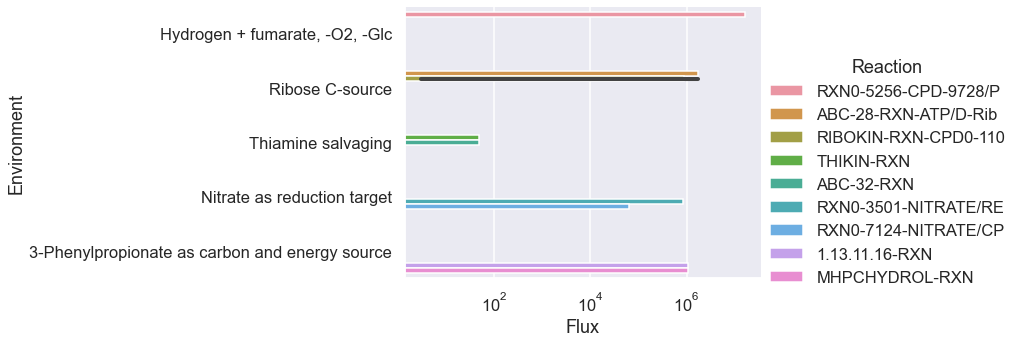

In [133]:
sns.catplot(y="Environment",hue="Reaction", x="Flux", data=results_df, kind="bar", aspect=2.5)
plt.xscale('log')
#plt.tight_layout()
plt.savefig("notebooks/fbagd/figures/rxns_light_up.png", dpi=300)

# Check metal reactions

In [ ]:
# find mets containing
mets_df[mets_df.loc[:, "Name"].str.contains("FE\+2\[c\]")]

# find reactions containing met
reactions_id = Sd.loc[ "FE+2[c]", Sd.iloc[1092, :] != 0].index
reactions_id

In [ ]:
# find reactions containing met
fluxes.loc[reactions_id,:]

# Troubleshoot wrong fluxes

In [ ]:
top_wrong = fluxes_wrong.sort_values(by=0, axis=1, ascending=False).T.head(50)
top_right = fluxes.sort_values(by=0, axis=1, ascending=False).T.head(50)

top_wrong.join(top_right, lsuffix="wrong", rsuffix="right")

In [ ]:
m2 = []

for rxn in ["LXULRU5P-RXN (reverse)", "RXN-21400", "RXN0-703 (reverse)", "RXN0-704", "RIBULPEPIM-RXN__EG12287-MONOMER", "RXN0-705__EG12285-MONOMER"]:
    m2.append({key: 2*value for key, value in stoichiometry[rxn].items()})
    
pd.DataFrame(m2, dtype=np.int8).fillna(0).astype(np.int8).sum(axis=0)

In [ ]:
m1 = []

for rxn in ["ALANINE-AMINOTRANSFERASE-RXN (reverse)", "MALATE-DEH-RXN (reverse)", "RXN-3523", "RXN-10981", \
 "RXN-12440", "CHD-RXN (reverse)", "RXN0-7230-CHOLINE/UBIQUINONE-8//BETAINE_ALDEHYDE/CPD-9956.48.", "ALARACECAT-RXN", "PMPOXI-RXN", "RXN0-5240"]:
    m1.append({key: value for key, value in stoichiometry[rxn].items()})
    
pd.DataFrame(m1, dtype=np.int8).fillna(0).astype(np.int8).sum(axis=0)

# Extract specific fluxes for balancing

In [ ]:
rxns_names = ['PGLUCISOM-RXN', '6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', 'TRIOSEPISOMERIZATION-RXN', 
              'GAPOXNPHOSPHN-RXN', 'PHOSGLYPHOS-RXN', '3PGAREARR-RXN',
              '2PGADEHYDRAT-RXN', 'PEPDEPHOS-RXN']

In [ ]:
fluxes.sort_values(by=0, axis=1, ascending=False).T.head(10)

In [ ]:
fluxes_small = fluxes.loc[fluxes.index.isin(rxns_names), :]
fluxes_small

In [ ]:
fluxes.loc[fluxes.index.str.contains("TRIOSEPISOMERIZATION-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("3PGAREARR-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("PHOSGLYPHOS-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("2TRANSKETO-RXN"),:]

# Glucose transport

In [ ]:
glucose_transport_reactions = ['TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.',
                               'RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//GLC/PROTON.23.',
                               'TRANS-RXN0-574-GLC//GLC.9.',
                               'TRANS-RXN0-574-GLC//Glucopyranose.19.',
                               'TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.',
                               'TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.',
                               'TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.']
